# Load Dependancies

In [1]:
project_name = 'dhcp'
import os
#get current working directory
cwd = os.getcwd()
git_dir = cwd.split(project_name)[0] + project_name
import sys

#add git_dir to path
sys.path.append(git_dir)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dhcp_params as params
from scipy import stats
import statsmodels.api as sm

from sklearn.manifold import MDS
#run repeated measures ANOVA
import pingouin as pg
import pdb

import warnings
warnings.filterwarnings("ignore")



In [2]:
atlas = 'wang'


#load atlast name and roi labels
atlas_info = params.load_atlas_info(atlas)
group_params = params.load_group_params('infant')

sub_info = group_params.sub_list
#subs2analyze['age'] = (subs2analyze['scan_age'] - subs2analyze['birth_age'])*7
sub_info['age'] = (sub_info['scan_age'] - sub_info['birth_age'])*7

subs2analyze = sub_info[(sub_info[f'{atlas}_exclude'] != 1) & (sub_info[f'{atlas}_ts'] == 1)]
group = 'infant'

age_bins = [26,33, 38,42,46]
age_groups = ['pre','early','term','post']
group_names = ['Pre-Term','Early-Term','Term','Post-Term']



#color code rois by network
#inds 1-7 are EVC
#inds 8-11 are ventral
#inds 12-17 are lateral
#inds 18-25 are dorsal

#add networks to roi labels
#roi_labels['network'] = ['Occipital']*6 + ['Ventral']*5 + ['Lateral']*6 + ['Dorsal']*7

networks = ['Occipital', 'Ventral', 'Lateral', 'Dorsal']
network_colors = ['#fd0000', '#be00fd', '#1105d8', 'green']

roi_labels = atlas_info.roi_labels

#expand roi labels to include hemis
all_rois = []
all_networks = []


all_rois = []
all_networks = []
for roi in roi_labels['label']:
    for hemi in params.hemis:
        all_rois.append(f'{hemi}_{roi}')
        all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])




## Dataset characteristics

Text(0, 0.5, 'Count')

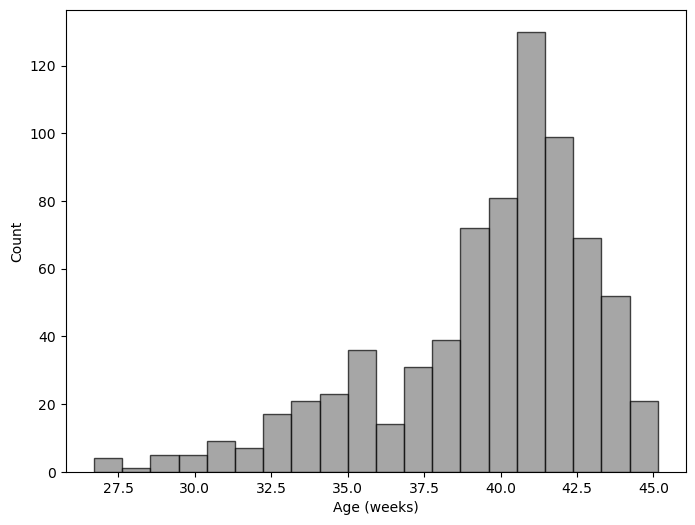

In [3]:
#create histogram of ages
plt.figure(figsize=(8, 6))

plt.hist(sub_info['scan_age'], color='gray', edgecolor='black', alpha=0.7, bins=20)
plt.xlabel('Age (weeks)')
plt.ylabel('Count')


## Identify infants with poor signal

Essentially, exclude any subs who are <2 SDs below the mean of the group

In [4]:
#load noise ceiling data
noise_df = pd.read_csv(f'{group_params.out_dir}/derivatives/noise_ceiling/infant_{atlas}_split_half_reliability.csv')

#add age column
noise_df['age'] = (noise_df['scan_age'] - noise_df['birth_age'])*7


#add age group column
noise_df['age_group'] = np.nan

for i in range(len(age_bins)-1):
    noise_df.loc[(noise_df['scan_age'] >= age_bins[i]) & (noise_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]
    subs2analyze.loc[(subs2analyze['scan_age'] >= age_bins[i]) & (subs2analyze['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]


#only include subs that are in subs2analyze
noise_df = noise_df[noise_df['ses'].isin(subs2analyze['ses'])]


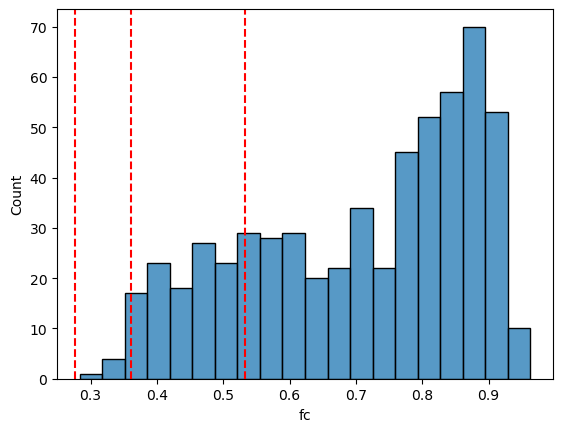

In [5]:
#compute average noise ceiling for each subject
noise_df_mean = noise_df.groupby(['sub', 'ses','age_group']).mean(numeric_only=True).reset_index()

#plot histogram of noise ceiling
plt.figure()
sns.histplot(noise_df_mean['fc'], bins=20)
#add line at SD = 1, 2
#compute SD of noise ceiling
sd = np.std(noise_df_mean['fc'])
mean = np.mean(noise_df_mean['fc'])
plt.axvline(x=mean- sd, color='r', linestyle='--')
plt.axvline(x=mean- (2*sd), color='r', linestyle='--')
plt.axvline(x=mean- (2.5*sd), color='r', linestyle='--')

In [6]:
#print how many subs are below 1, 2, 2.5 SD
print(f'Number of subs below 1 SD: {len(noise_df_mean[noise_df_mean["fc"] < mean-sd])}')
print(f'Number of subs below 2 SD: {len(noise_df_mean[noise_df_mean["fc"] < mean-(2*sd)])}')
print(f'Number of subs below 2.5 SD: {len(noise_df_mean[noise_df_mean["fc"] < mean-(2.5*sd)])}')

#print number of subs of each age group below 1, 2, 2.5 SD
for age_group in age_groups:
    print(f'Number of {age_group} subs below 2 SD: {len(noise_df_mean[(noise_df_mean["fc"] < mean-(2*sd)) & (noise_df_mean["age_group"] == age_group)])} out of {len(noise_df_mean[noise_df_mean["age_group"] == age_group])}')
    

Number of subs below 1 SD: 121
Number of subs below 2 SD: 6
Number of subs below 2.5 SD: 0
Number of pre subs below 2 SD: 0 out of 29
Number of early subs below 2 SD: 1 out of 98
Number of term subs below 2 SD: 3 out of 304
Number of post subs below 2 SD: 2 out of 153


In [14]:
#count number of subs where wang_ts ==1 and wang_exclude == ''
print(sub_info[(sub_info['wang_ts'] == 1) & (np.isnan(sub_info['wang_exclude']))].shape[0])
#count number of subs where wang_ts ==1 and wang_exclude == 1
print(sub_info[(sub_info['wang_ts'] == 1) & (sub_info['wang_exclude'] == 1)].shape[0])

584
117


In [16]:
#print number of day 1 subs
print(f'Number of day 1 subs: {len(subs2analyze[(subs2analyze['age'] <= 1) & (subs2analyze['age_group'] == "term") | (subs2analyze['age'] <= 1) & (subs2analyze['age_group'] == "post")])}')

#print number of subjects in each group total
for age_group in age_groups:
    print(f'Number of {age_group} subs: {len(subs2analyze[subs2analyze["age_group"] == age_group])}')

Number of day 1 subs: 40
Number of pre subs: 29
Number of early subs: 98
Number of term subs: 304
Number of post subs: 153


In [8]:
#mark subs with noise ceiling below 2 SD in sub_info sheet
sub_info[f'{atlas}_exclude'] = sub_info[f'{atlas}_exclude'].astype(str)
sub_info[f'{atlas}_exclude'] = sub_info[f'{atlas}_exclude'].replace('nan', '')

for sub in noise_df_mean[noise_df_mean['fc'] < mean-(2*sd)]['sub']:
    sub_info.loc[sub_info['participant_id'] == sub, f'{atlas}_exclude'] = '1'

In [9]:
#save sub_info sheet
sub_info.to_csv(f'{git_dir}/participants_dhcp.csv', index=False)

### Plot Noise ceilings for each age group

Text(0.5, 0, 'Age Group')

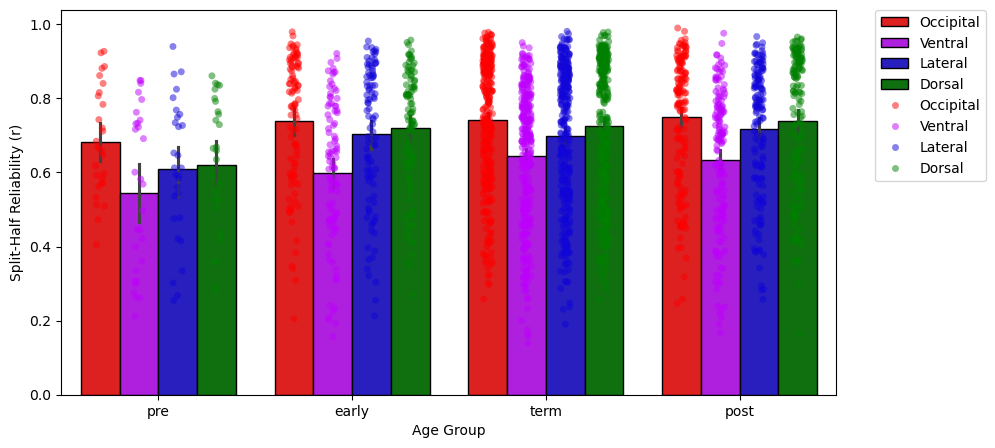

In [7]:


#set network and age_group as categorical
noise_df['network'] = pd.Categorical(noise_df['network'], categories=networks, ordered=True)
noise_df['age_group'] = pd.Categorical(noise_df['age_group'], categories=age_groups, ordered=True)

#only include subs that are in subs2analyze
noise_df = noise_df[noise_df['sub'].isin(subs2analyze['participant_id'])]



#summarize data by network and age group
noise_df = noise_df.groupby(['sub', 'ses', 'network', 'age_group']).mean(numeric_only=True).reset_index()





#plot noise ceiling by network and age group as bar graphs
plt.figure(figsize=(10,5))
sns.barplot(x='age_group', y='fc', data=noise_df,hue='network', palette=network_colors, edgecolor='k', errorbar=('ci',95))
#add individual data points
sns.stripplot(x='age_group', y='fc', data=noise_df, hue='network', dodge=True, palette=network_colors, edgecolor='k', alpha=0.5)

#put legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#set y axis label 
plt.ylabel('Split-Half Reliability (r)')

#set x axis label
plt.xlabel('Age Group')

(0.3, 1.0)

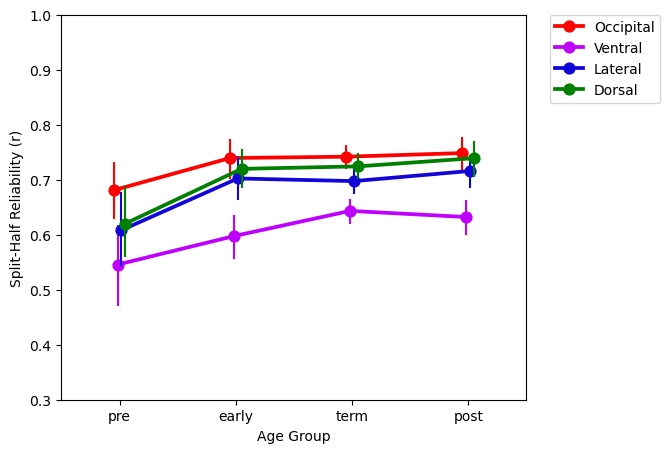

In [8]:
#plot noise ceiling as point_plot
plt.figure(figsize=(6,5))
sns.pointplot(x='age_group', y='fc', data=noise_df, hue='network', palette=network_colors, ci=95, dodge=True, markers='o', linestyles='-', errwidth=1.5, capsize=0)

#change y axis label to 'Split-Half Reliability (r)'
plt.ylabel('Split-Half Reliability (r)')
#change x axis label to 'Age Group'
plt.xlabel('Age Group')

#put legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#set y lim to 0.2 to 1
plt.ylim(0.3,1)


## Arealization analyses

In [7]:
#load infant data
sub_df = pd.read_csv(f'{group_params.out_dir}/derivatives/{atlas}/infant_{atlas}_roi_similarity.csv')
adj_rois = pd.read_csv(f'{git_dir}/analysis/Wang_adjacent_labels.csv')

#add age and age group columns
sub_df['age'] = (sub_df['scan_age'] - sub_df['birth_age'])*7
sub_df['age_group'] = np.nan
for i in range(len(age_bins)-1):
    sub_df.loc[(sub_df['scan_age'] >= age_bins[i]) & (sub_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]





In [8]:
'''load and process adult data'''

adult_fc = pd.read_csv(f'{git_dir}/results/fc_mat/adult_{atlas}_fc_mat.csv', index_col = 0).values
#set diagonal to nan
np.fill_diagonal(adult_fc, np.nan)

#convert to pandas dataframe and melt
adult_df = pd.DataFrame(adult_fc, index = all_rois, columns = all_rois)


#melt so that you have an roi1 and roi1 column
adult_df = adult_df.melt(var_name = 'roi2', value_name = 'fc', ignore_index = False).reset_index().rename(columns = {'index':'roi1'})
adult_df = adult_df.dropna()

#add network labels
adult_df['network1'] = [all_networks[all_rois.index(roi)] for roi in adult_df['roi1']]
adult_df['network2'] = [all_networks[all_rois.index(roi)] for roi in adult_df['roi2']]

#split roi into hemi and roi
adult_df['hemi1'] = adult_df['roi1'].apply(lambda x: x.split('_')[0])
adult_df['roi1'] = adult_df['roi1'].apply(lambda x: x.split('_')[1])

adult_df['hemi2'] = adult_df['roi2'].apply(lambda x: x.split('_')[0])
adult_df['roi2'] = adult_df['roi2'].apply(lambda x: x.split('_')[1])

#add roi_similarity, network_similarity, and hemi_similarity columns
adult_df['roi_similarity'] = ['same' if roi1 == roi2 else 'diff' for roi1, roi2 in zip(adult_df['roi1'], adult_df['roi2'])]
adult_df['network_similarity'] = ['same' if network1 == network2 else 'diff' for network1, network2 in zip(adult_df['network1'], adult_df['network2'])]
adult_df['hemi_similarity'] = ['same' if hemi1 == hemi2 else 'diff' for hemi1, hemi2 in zip(adult_df['hemi1'], adult_df['hemi2'])]

#extract only diff hemispheres
adult_df = adult_df[adult_df['hemi_similarity'] == 'diff']

#groupby roi1, roi2, roi_similarity,  network_similarity, roi_similarity_adj
adult_df = adult_df.groupby(['roi1', 'roi2', 'roi_similarity', 'network_similarity']).mean(numeric_only=True).reset_index()

#create column for  same, adjacent, and distant areas
#add adjacency category to roi_similarity
#loop over roi1 and if roi2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
adult_df['roi_similarity_adj'] = np.nan


#label same, adjacent, and distant areas
for roi1,adj1, adj2 in zip(adj_rois['label'], adj_rois['adjacent1'], adj_rois['adjacent2']):
    #if ro2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
    adult_df['roi_similarity_adj'] = np.where((adult_df['roi1'] == roi1) & (adult_df['roi2'] == adj1) | (adult_df['roi1'] == roi1) & (adult_df['roi2'] == adj2),
                                                     'Adjacent', adult_df['roi_similarity_adj'])
    
    #if roi1 == roi2, set roi_similarity to same
    adult_df['roi_similarity_adj'] = np.where(adult_df['roi1'] == adult_df['roi2'], 'Same\nArea', adult_df['roi_similarity_adj'])

    #if roi1 != roi2 and roi_similarity_adj is nan, set roi_similarity to distant
    adult_df['roi_similarity_adj'] = np.where((adult_df['roi1'] != adult_df['roi2']) & (adult_df['roi_similarity_adj'] != 'Adjacent') & (adult_df['roi_similarity_adj'] != 'same'),
                                                     'Distal', adult_df['roi_similarity_adj'])



#### Compute Arealization overall

In [9]:
def create_mat(df,col = 'fc', roi_labels=all_rois):
    #create empty matrix to store infant data
    mat = np.zeros((len(roi_labels), len(roi_labels)))

    #fill in infant matrix with infant data
    for i, roi1 in enumerate(roi_labels):
        for j, roi2 in enumerate(roi_labels):
            mat[i,j] = df[(df['roi1'] == roi1) & (df['roi2'] == roi2)][col].values[0]

    return mat

def plot_fc_matrix(corr_mat, roi_labels, file_name):
    #make diagonal to nans
    corr_mat = np.array(corr_mat)
    print(corr_mat.shape)
    #corr_mat = np.fill_diagonal(corr_mat, np.nan)

    #extract upper triangle
    corr_mat = np.tril(corr_mat)

    #set 0s to nans
    corr_mat[corr_mat == 0] = np.nan


    sns.heatmap(corr_mat, cmap= 'coolwarm', cbar =False, vmin=0, vmax=.8, xticklabels = False, yticklabels = False)
    #make bigger 
    plt.gcf().set_size_inches(12,12)

    #add labels from all_labels
    plt.xticks(np.arange(0.5, len(roi_labels), 1), roi_labels, rotation = 90, fontsize = 14)
    plt.yticks(np.arange(0.5, len(roi_labels), 1), roi_labels, rotation = 0, fontsize = 14)

  
   
    

    #make background black
    ax = plt.gca()

    #make plot square
    ax.set_aspect('equal', 'box')

    #make background white
    ax.set_facecolor('white')

    

    if file_name is not None:
        plt.savefig(f'{git_dir}/figures/{file_name}.png', dpi=300, bbox_inches='tight')    

    plt.show()
    plt.pause(.001)



In [10]:
#load adjacency file for rois
adj_rois = pd.read_csv(f'{git_dir}/analysis/Wang_adjacent_labels.csv')

#extract day 1 data
# extract infants that were scanned on day 1 and are either term or post-term
curr_df = sub_df[(sub_df['age'] <= 1) & (sub_df['age_group'] == 'term') | (sub_df['age'] <= 1) & (sub_df['age_group'] == 'post')]


curr_df_median = curr_df.groupby(by=['hemi1', 'roi1', 'hemi2','roi2', 'roi_similarity', 'hemi_similarity']).median(numeric_only=True).reset_index()

#extract hemi_similarity == diff
curr_df_diff = curr_df_median[curr_df_median['hemi_similarity'] == 'diff']

#average by roi1 and roi2, roi_similairty
curr_df_diff = curr_df_diff.groupby(by=['roi1', 'roi2', 'roi_similarity']).mean(numeric_only=True).reset_index()

#extract fc matrix
fc_mat = create_mat(curr_df_diff, col = 'fc', roi_labels = adj_rois['label'].to_list())
#convert to pandas df
fc_mat_df = pd.DataFrame(fc_mat, columns = adj_rois['label'].to_list(), index = adj_rois['label'].to_list())


(24, 24)


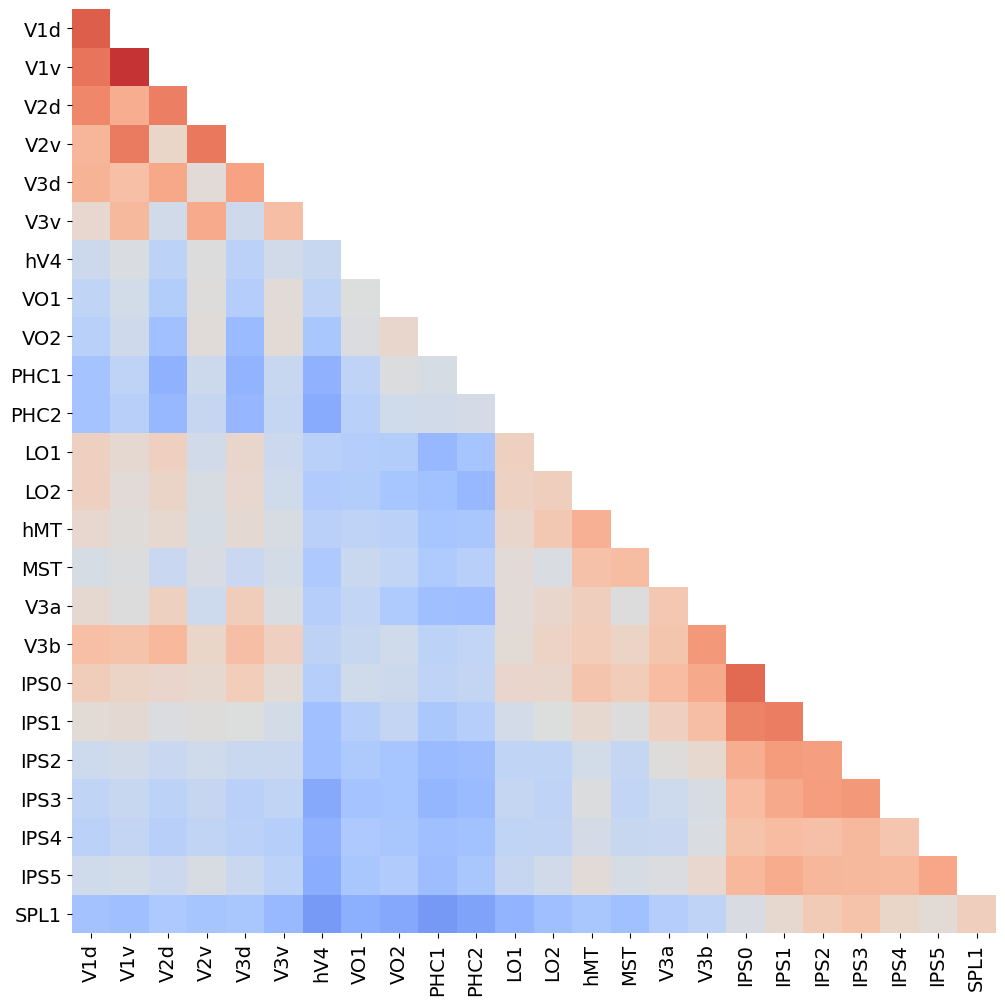

In [11]:

#create heatmap
plot_fc_matrix(fc_mat_df, adj_rois['label'].to_list(), 'arealization/infant_day1_arealization')

#save figure
#plt.savefig(f'{git_dir}/figures/arealization/infant_day1_arealization.png')


(24, 24)


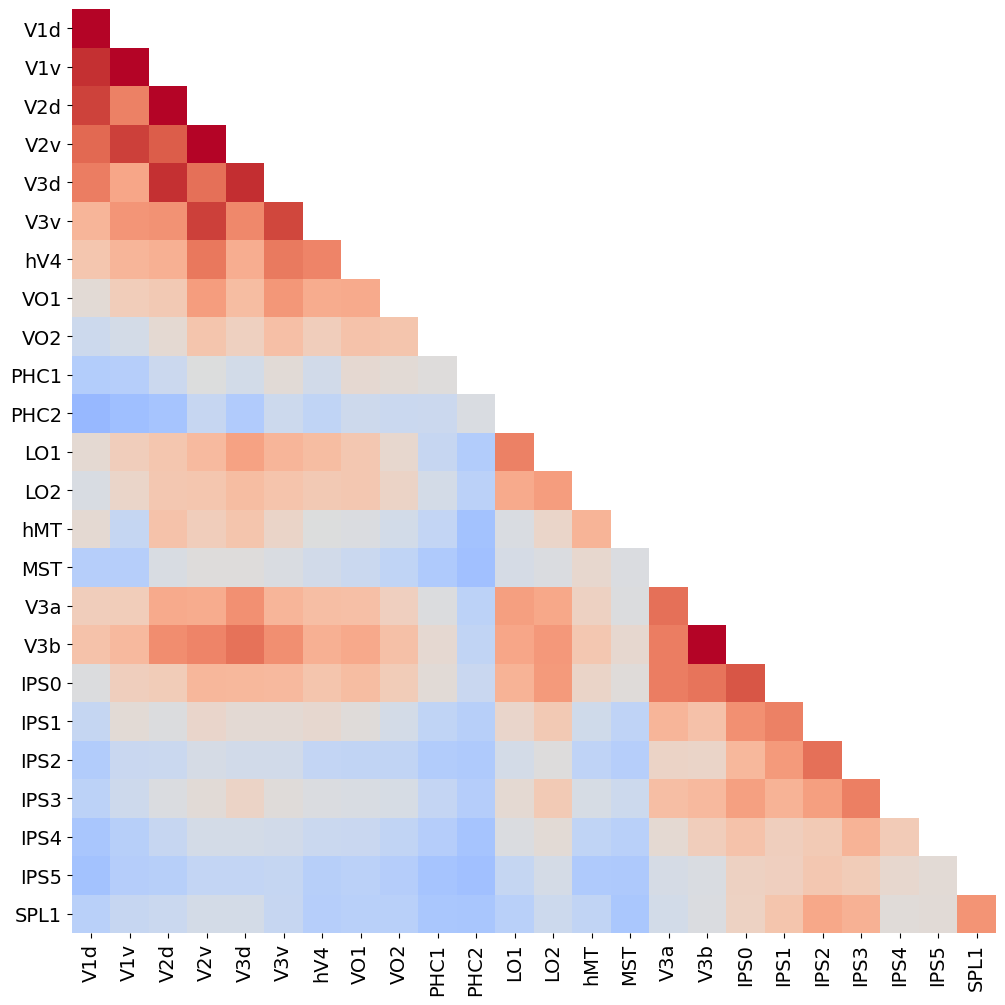

<Figure size 640x480 with 0 Axes>

In [12]:
#create adult heatmap
#extract fc matrix
adult_mat = create_mat(adult_df, col = 'fc', roi_labels = adj_rois['label'].to_list())
#convert to pandas df
adult_mat_df = pd.DataFrame(adult_mat, columns = adj_rois['label'].to_list(), index = adj_rois['label'].to_list())


#create heatmap
plot_fc_matrix(adult_mat_df, adj_rois['label'].to_list(), 'adult_arealization')

#save figure
plt.savefig(f'{git_dir}/figures/arealization/adult_arealization.png')

#### Add distances to data summary

In [13]:
#group by ROIs
df_roi_summary = curr_df.groupby(['sub', 'ses', 'roi1','roi2','hemi_similarity','roi_similarity','network_similarity']).mean(numeric_only=True).reset_index()
df_roi_summary = df_roi_summary[df_roi_summary['hemi_similarity'] == 'diff']

#add adjacency category to roi_similarity
#loop over roi1 and if roi2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
df_roi_summary['roi_similarity_adj'] = np.nan


#label same, adjacent, and distant areas
for roi1,adj1, adj2 in zip(adj_rois['label'], adj_rois['adjacent1'], adj_rois['adjacent2']):
    #if ro2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
    df_roi_summary['roi_similarity_adj'] = np.where((df_roi_summary['roi1'] == roi1) & (df_roi_summary['roi2'] == adj1) | (df_roi_summary['roi1'] == roi1) & (df_roi_summary['roi2'] == adj2),
                                                     'Adjacent', df_roi_summary['roi_similarity_adj'])
    
    #if roi1 == roi2, set roi_similarity to same
    df_roi_summary['roi_similarity_adj'] = np.where(df_roi_summary['roi1'] == df_roi_summary['roi2'], 'Same\nArea', df_roi_summary['roi_similarity_adj'])

    #if roi1 != roi2 and roi_similarity_adj is nan, set roi_similarity to distant
    df_roi_summary['roi_similarity_adj'] = np.where((df_roi_summary['roi1'] != df_roi_summary['roi2']) & (df_roi_summary['roi_similarity_adj'] != 'Adjacent') & (df_roi_summary['roi_similarity_adj'] != 'same'),
                                                     'Distal', df_roi_summary['roi_similarity_adj'])


#### Plot as bars

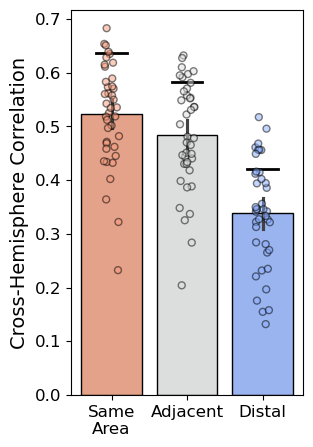

In [19]:
#group by roi_similarity_adj
df_areal_summary = df_roi_summary.groupby(['sub', 'ses', 'roi_similarity_adj']).mean(numeric_only=True).reset_index()

adult_df_areal_summary = adult_df.groupby(['roi_similarity_adj']).mean(numeric_only=True).reset_index()


comp_order = ['Same\nArea', 'Adjacent', 'Distal']

#make roi_network_similarity a categorical variable
df_areal_summary['roi_similarity_adj'] = pd.Categorical(df_areal_summary['roi_similarity_adj'], categories=comp_order, ordered=True)
adult_df_areal_summary['roi_similarity_adj'] = pd.Categorical(adult_df_areal_summary['roi_similarity_adj'], categories=comp_order, ordered=True)
#reorder adult_df to match comp_order
adult_df_areal_summary = adult_df_areal_summary.sort_values(by='roi_similarity_adj')

#plot arealization by roi_network_similarity

sns.barplot(x='roi_similarity_adj', y='fc', data=df_areal_summary, palette='coolwarm_r', edgecolor='k', errorbar=('ci',95))

#add individual data points with same colors as bar plot
sns.stripplot(x='roi_similarity_adj', y='fc', data=df_areal_summary, marker = 'o',palette='coolwarm_r', edgecolor='k', linewidth=1,alpha=.5)

#add black line above each bar for adult data
for i, val in enumerate(adult_df_areal_summary['fc']):
    plt.plot([i-0.2, i+0.2], [val, val], color = 'k', linewidth = 2)


#change figure size
plt.gcf().set_size_inches(3,5)

#remove x axis label
plt.xlabel('')
#rename Y-axis label
plt.ylabel('Cross-Hemisphere Correlation', fontsize=14)

#set x-axis fontsize
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#save figure
plt.savefig(f'{git_dir}/figures/arealization/infant_day1_barplot.png', bbox_inches='tight', dpi=300)

In [15]:


#run repeated measures ANOVA
aovrm = pg.rm_anova(dv='fc', within='roi_similarity_adj', subject='sub', data=df_areal_summary, effsize='np2')

print(aovrm)

#run pairwise comparisons
post_hocs = pg.pairwise_ttests(dv='fc', within='roi_similarity_adj', subject='sub', data=df_areal_summary, padjust='holm', effsize='cohen')
print(post_hocs)

               Source  ddof1  ddof2           F         p-unc     np2  \
0  roi_similarity_adj      2     78  493.062589  5.482434e-45  0.9267   

        eps  
0  0.623834  
             Contrast           A         B  Paired  Parametric          T  \
0  roi_similarity_adj  Same\nArea  Adjacent    True        True  12.930581   
1  roi_similarity_adj  Same\nArea    Distal    True        True  23.856234   
2  roi_similarity_adj    Adjacent    Distal    True        True  21.516474   

    dof alternative         p-unc        p-corr p-adjust       BF10     cohen  
0  39.0   two-sided  1.106230e-15  1.106230e-15     holm  5.736e+12  0.415538  
1  39.0   two-sided  7.165786e-25  2.149736e-24     holm  4.498e+21  1.903487  
2  39.0   two-sided  3.041123e-23  6.082246e-23     holm  1.183e+20  1.448497  


#### Plot roi level analysis

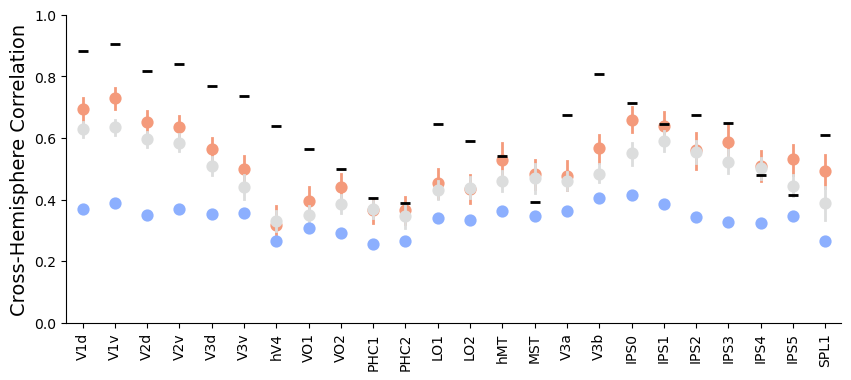

In [18]:
'''
Plot the value of same, adjacent, and distant areas for each ROI
'''

#set order for area distance
df_roi_summary['roi_similarity_adj'] = pd.Categorical(df_roi_summary['roi_similarity_adj'], categories=comp_order, ordered=True)
#set order for rois
df_roi_summary['roi1'] = pd.Categorical(df_roi_summary['roi1'], categories=adj_rois['label'], ordered=True)

#rename same\nare to same area


#extract same area data from adult
adult_df_same = adult_df[adult_df['roi_similarity_adj'] == 'Same\nArea']
#set categorical variables for adult_roi_summary
adult_df['roi1'] = pd.Categorical(adult_df['roi1'], categories=adj_rois['label'], ordered=True)

#Plot each ROI as a point plot, where x is roi1 and hue is roi_similarity_adj
sns.pointplot(x='roi1', y='fc', data=df_roi_summary, hue='roi_similarity_adj',palette = 'coolwarm_r', ci=95, dodge=False, markers='o', linestyles='', errwidth=2, capsize=0, )

#plot adult data as black lines
sns.pointplot(x='roi1', y='fc', data=adult_df_same, ci=95, dodge=True, markers='_', linestyles='', errwidth=1.5, capsize=0, color='k')

#hide legend
plt.legend().remove()

#change plot size
plt.gcf().set_size_inches(10,4)

#set ylim 
plt.ylim([0, 1])

#angle x axis labels
plt.xticks(rotation=90)

#remove top and right spines
sns.despine()

#add y axis label
plt.ylabel('Cross-Hemisphere Correlation', fontsize = 14)

#remove X axis label
plt.xlabel('')

#save figure
plt.savefig(f'{git_dir}/figures/arealization/infant_day1_roi_pointplot.png', bbox_inches='tight', dpi = 300)

#### Compute arealization index as same-adjacent and correlate to adults

In [17]:

#group by roi1 and roi_similarity_adj
df_roi_index = df_roi_summary.groupby(['roi1', 'roi_similarity_adj']).mean(numeric_only=True).reset_index()
#remove rows with 
df_adult_roi = adult_df.groupby(['roi1', 'roi_similarity_adj']).mean(numeric_only=True).reset_index()

#remove rows with distal
df_roi_index = df_roi_index[df_roi_index['roi_similarity_adj'] != 'Distal']
df_adult_roi = df_adult_roi[df_adult_roi['roi_similarity_adj'] != 'Distal']


#pivot table so that each roi is a row and each column is a roi_similarity_adj
df_roi_index = df_roi_index.pivot(index='roi1', columns='roi_similarity_adj', values='fc')
df_adult_roi = df_adult_roi.pivot(index='roi1', columns='roi_similarity_adj', values='fc')
#create new col for each with the difference between same and adjacent
df_roi_index['areal_ratio'] = df_roi_index['Same\nArea'] - df_roi_index['Adjacent']
df_adult_roi['areal_ratio'] = df_adult_roi['Same\nArea'] - df_adult_roi['Adjacent']

#correlate neonate and adult ratios
corr = stats.pearsonr(df_roi_index['areal_ratio'], df_adult_roi['areal_ratio'])

print(corr)





PearsonRResult(statistic=0.547451559377629, pvalue=0.005624802935962452)


## Compute cluster grouping

In [6]:
#load infant data
infant_df = pd.read_csv(f'{group_params.out_dir}/derivatives/{atlas}/infant_{atlas}_roi_similarity.csv')

#add age and age group columns
infant_df['age'] = (infant_df['scan_age'] - infant_df['birth_age'])*7
infant_df['age_group'] = np.nan
for i in range(len(age_bins)-1):
    infant_df.loc[(infant_df['scan_age'] >= age_bins[i]) & (infant_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]





#### Conduct analyses on day1 infants

### Plot network and ROI clustering

In [7]:
def create_network_plot(df_network_summary, filename = None):
        
    #group by roi1 and roi2
    df_network_summary = df_network_summary.groupby(['sub', 'network1', 'network_similarity']).mean(numeric_only=True).reset_index()

    #extract only same network_similarity
    #df_roi_summary = df_roi_summary[df_roi_summary['network_similarity'] == 'same']
    network_colors = ['#fd0000', '#be00fd', '#1105d8', 'green']
    network_order= ['Occipital','Ventral','Lateral','Dorsal']


    '''plot sub data at network level'''

    #set network order
    network_order = ['Occipital', 'Ventral', 'Lateral', 'Dorsal']
    comp_order = ['same','diff']
    #comp_order = ['Same\nRegion','Same\nNetwork','Different\nNetwork']


    #set network order as categorical and level order
    df_network_summary['network_similarity'] = pd.Categorical(df_network_summary['network_similarity'], categories=comp_order, ordered=True)
    #df_summary_grouped['infant_network'] = pd.Categorical(df_summary_grouped['infant_network'], categories=network_order, ordered=True)


    #create list of 12 gray colors
    network_colors = [['#fd0000','gray'], ['#be00fd', 'gray'], ['#1105d8', 'gray'], ['green', 'gray']]

    #loop through networks and create subplot for each
    #set subplot size
    fig,ax = plt.subplots(1,4,figsize=(10,3.5),sharey=False)
    for i in range(0,len(network_order)):
        #print(network_order[i])
        curr_data = df_network_summary[(df_network_summary['network1']==network_order[i]) & (df_network_summary['network_similarity'] == 'same') | (df_network_summary['network1']==network_order[i]) & (df_network_summary['network_similarity'] == 'diff')]
        
        print(curr_data.groupby(['network1','network_similarity'])['dist'].mean())
        
        

        #add dotted line for noise ceiling 
        #noise_df = noise_ceil[(noise_ceil['network1'] == network_order[i]) & (noise_ceil['network_similarity'] == 'same')]
        #ax[i].axhline(y=noise_df['dist'].values[0], color = network_colors[i][0], linestyle = '--')
        
        #plot summary_df
        sns.violinplot(data=curr_data, x= 'network1', y= 'dist', hue='network_similarity',
                    split = True,gap = .2, alpha = .8, inner = 'quart', palette = network_colors[i], ax = ax[i])



        sns.stripplot(data = curr_data,  x= 'network1', y= 'dist', hue = 'network_similarity', 
                    dodge=True,edgecolor = 'black',  linewidth=1,jitter = .2, size = 6,
                        palette = network_colors[i], ax = ax[i],alpha=.5)


        #set y limits
        ax[i].set_ylim([0,4.5])

        #set y interval
        ax[i].set_yticks(np.arange(0,5,1))

        #add y label
        if i == 0:

            ax[i].set_ylabel('Network Distance', fontsize = 14)
            #make axes black
            ax[i].spines['left'].set_color('k')

        
        
        else:
            
            #remove y label
            ax[i].set_ylabel('')
            #remove y ticks
            ax[i].set_yticks([])
            #remove y tick labels
            ax[i].set_yticklabels([])
            #remove y axis line
            ax[i].spines['left'].set_visible(False)

        #remove x ticks and labels
        ax[i].set_xticks([])
        ax[i].set_xticklabels([])
        
        #add network as xlabel for each subplort
        ax[i].set_xlabel(network_order[i], fontsize = 14)
        #add x label
        #plt.xlabel('Network', fontsize = 20)

        #make axes black
        ax[i].spines['bottom'].set_color('k')
        

        #remove top and right axes
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)

        #remove legend
        ax[i].get_legend().remove()
        #reverse y axis
        ax[i].invert_yaxis()

        

    plt.subplots_adjust(wspace=.1, hspace=0)

    if filename is not None:
        plt.savefig(f'{git_dir}/figures/cluster/{filename}.png', bbox_inches='tight', dpi = 300)

    plt.show()
    plt.pause(.001)



Plotting network similarity data for both hemis
network1   network_similarity
Occipital  same                  1.104329
           diff                  1.667927
Name: dist, dtype: float64
network1  network_similarity
Ventral   same                  1.118923
          diff                  1.788157
Name: dist, dtype: float64
network1  network_similarity
Lateral   same                  1.039576
          diff                  1.488196
Name: dist, dtype: float64
network1  network_similarity
Dorsal    same                  1.239366
          diff                  1.765451
Name: dist, dtype: float64


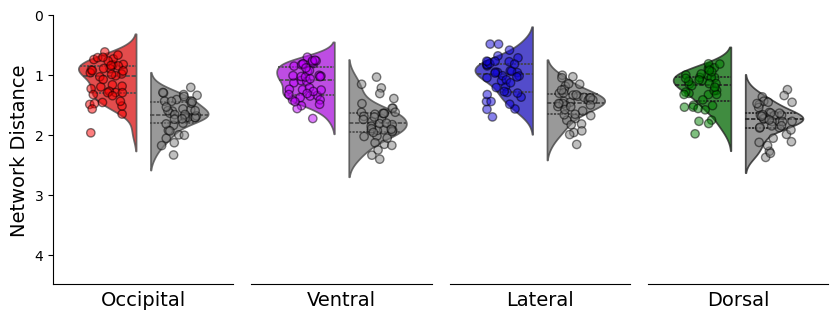

In [8]:
'''
Plot network similarity data
Both hemis
'''
print('Plotting network similarity data for both hemis')
dist_summary = pd.read_csv(f'{group_params.out_dir}/derivatives/clustering/infant_all_{atlas}_roi_distance.csv')
#adult_dist = pd.read_csv(f'{git_dir}/results/clustering/adult_{atlas}_roi_distance.csv')

#extract day 1 infants
#subtract birth age from scan age to get age
dist_summary['age'] = (dist_summary['scan_age'] - dist_summary['birth_age'])*7

#extract infants that were scanned on day 1 and are either term or post-term
day1_summary = dist_summary[(dist_summary['age'] <= 1) & (dist_summary['age_group'] == 'term') | (dist_summary['age'] <= 1) & (dist_summary['age_group'] == 'post')]

#remove rows where roi_similarity is same
df_network_summary = day1_summary[(day1_summary['roi_similarity'] != 'same')]
#group by sub, network, network_similarity
df_network_summary = df_network_summary.groupby(['sub', 'network1', 'network_similarity']).mean(numeric_only=True).reset_index()
#adult_network_summary = adult_dist[(adult_dist['roi_similarity'] == 'diff') & (adult_dist['network_similarity'] == 'same')]

#plot network similarity data
create_network_plot(df_network_summary, filename = 'infant_day1_network_distance')



Plotting network similarity data across hemis
network1   network_similarity
Occipital  same                  1.164936
           diff                  1.697595
Name: dist, dtype: float64
network1  network_similarity
Ventral   same                  1.222453
          diff                  1.814275
Name: dist, dtype: float64
network1  network_similarity
Lateral   same                  1.177448
          diff                  1.527936
Name: dist, dtype: float64
network1  network_similarity
Dorsal    same                  1.277979
          diff                  1.785085
Name: dist, dtype: float64


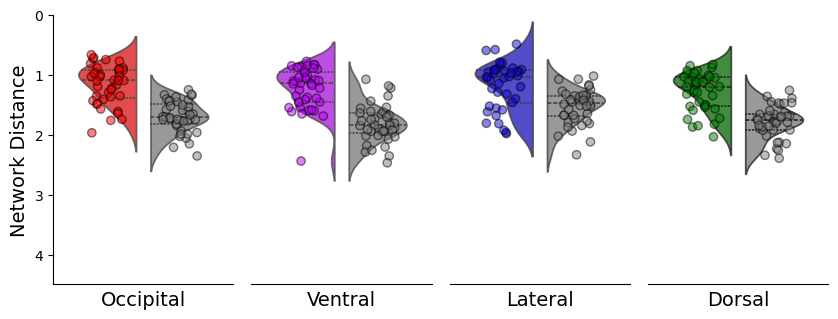

In [9]:
'''
Plot network distance data
Across hemis
'''
print('Plotting network similarity data across hemis')
#dist_summary = pd.read_csv(f'{git_dir}/results/clustering/infant_day1_{atlas}_roi_distance.csv')

#remove rows where roi_similarity is same
df_network_summary = day1_summary[(day1_summary['roi_similarity'] == 'diff') & (day1_summary['hemi_similarity'] == 'diff')]
df_network_summary = df_network_summary.groupby(['sub', 'network1', 'network_similarity']).mean(numeric_only=True).reset_index()

#plot network similarity data
create_network_plot(df_network_summary, filename = 'infant_day1_network_distance_across_hemis')



In [10]:
'''Conduct analysis'''
#load infant dist summary
dist_df = day1_summary

#Exclude same rois with same hemi and same roi
dist_df = dist_df[(dist_df['roi_similarity'] != 'same') & (dist_df['hemi_similarity'] != 'same')]

#group by sub, network1, network_similarity
dist_summary = dist_df.groupby(['sub','network1','network_similarity']).mean(numeric_only=True).reset_index()

#run repeated measures ANOVA with network1 and network_similarity as the within subject
aovrm = pg.rm_anova(dv='dist', within=['network1', 'network_similarity'], subject='sub', data=dist_summary, effsize='np2')

print(aovrm)

#run pairwise comparisons
post_hocs = pg.pairwise_ttests(dv='dist', within=['network1', 'network_similarity'], subject='sub', data=dist_summary, padjust='holm', effsize='cohen')
print(post_hocs)


                          Source         SS  ddof1  ddof2         MS  \
0                       network1   1.668354      3    117   0.556118   
1             network_similarity  19.643106      1     39  19.643106   
2  network1 * network_similarity   0.636441      3    117   0.212147   

            F         p-unc     p-GG-corr       np2       eps  
0   10.500834  3.610186e-06  2.317500e-05  0.212134  0.807788  
1  319.473181  2.193845e-20  2.193845e-20  0.891205  1.000000  
2    5.093640  2.382720e-03  3.246662e-03  0.115519  0.917071  
                         Contrast   network1          A          B Paired  \
0                        network1          -     Dorsal    Lateral   True   
1                        network1          -     Dorsal  Occipital   True   
2                        network1          -     Dorsal    Ventral   True   
3                        network1          -    Lateral  Occipital   True   
4                        network1          -    Lateral    Ventral   T

In [11]:
def create_roi_plot(df_roi_summary, filename=None):
        
    #group by roi1 and roi2
    df_roi_summary = df_roi_summary.groupby(['network1', 'roi1', 'network2', 'roi2', 'network_similarity']).mean(numeric_only=True).reset_index()

    #extract only same network_similarity
    #df_roi_summary = df_roi_summary[df_roi_summary['network_similarity'] == 'same']
    network_colors = ['#fd0000','#be00fd', '#1105d8','green']
    network_order= ['Occipital','Ventral','Lateral','Dorsal']


    #set network order as categorical and level order
    df_roi_summary['roi1'] = pd.Categorical(df_roi_summary['roi1'], categories=adj_rois['label'], ordered=True)
    df_roi_summary['network2'] = pd.Categorical(df_roi_summary['network2'], categories=network_order, ordered=True)

    #fig,ax = plt.subplots(1,1,figsize=(10,3.5),sharey=False)
    plt.figure(figsize=(10, 3.5))

    sns.stripplot(data = df_roi_summary, x = 'roi1', y = 'dist', hue = 'network2', palette = network_colors, linewidth = .5, s = 5, edgecolor = 'k',jitter=.1,zorder = 0)

    #set ylim
    #plt.ylim([.8, 3])

    #set y interval
    plt.yticks(np.arange(0.5,3.5,.5))

    #create scatter plot of noise ceiling
    #sns.scatterplot(data = df_noise_roi, x = 'roi1', y = 'corr', color = 'black', linewidth = 1, s = 100, marker="_", edgecolor = 'k', legend = False, zorder =15)

    #remove legend
    plt.legend([],[], frameon=False)

    #change plot size
    plt.gcf().set_size_inches(10,3.5)

    #angle x axis labels
    plt.xticks(rotation=90)

    #invert y axis
    plt.gca().invert_yaxis()

    #put x axis on top
    #plt.gca().xaxis.tick_top()

    #remove top and right spines
    sns.despine()

    #add y axis label
    plt.ylabel('Area Distance', fontsize = 14)

    #remove X axis label
    plt.xlabel('')
    

    if filename is not None:
        plt.savefig(f'{git_dir}/figures/cluster/{filename}.png', bbox_inches='tight', dpi = 300)

    plt.show()
    plt.pause(.001)

    

Plotting roi similarity data for both hemis


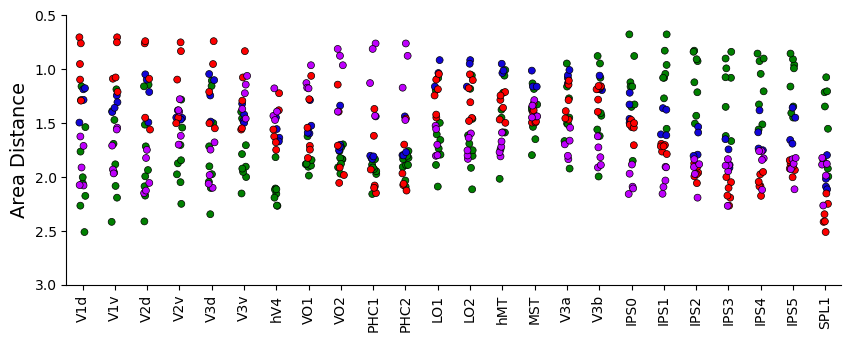

" \nPLot data from only cross- hemis\n\nprint('Plotting roi similarity data across hemis')\ndist_summary = pd.read_csv(f'{git_dir}/results/clustering/infant_day1_{atlas}_roi_distance.csv')\n\n#remove rows where roi_similarity is same\ndf_roi_summary = dist_summary[(dist_summary['roi_similarity'] == 'diff') & (dist_summary['hemi_similarity'] == 'diff')]\n\n#plot roi similarity data\ncreate_roi_plot(df_roi_summary, filename = 'infant_day1_roi_distance_cross_hemis')\n"

In [12]:
'''
Plot data at roi level

This include both hemis
'''
print('Plotting roi similarity data for both hemis')
dist_summary = day1_summary

#remove rows where roi_similarity is same
df_roi_summary = dist_summary[dist_summary['roi_similarity'] == 'diff']

#plot roi similarity data
create_roi_plot(df_roi_summary, filename = 'infant_day1_roi_distance')

''' 
PLot data from only cross- hemis

print('Plotting roi similarity data across hemis')
dist_summary = pd.read_csv(f'{git_dir}/results/clustering/infant_day1_{atlas}_roi_distance.csv')

#remove rows where roi_similarity is same
df_roi_summary = dist_summary[(dist_summary['roi_similarity'] == 'diff') & (dist_summary['hemi_similarity'] == 'diff')]

#plot roi similarity data
create_roi_plot(df_roi_summary, filename = 'infant_day1_roi_distance_cross_hemis')
'''



### Plot grouping by agegroup

In [13]:
dist_summary = pd.read_csv(f'{group_params.out_dir}/derivatives/clustering/infant_all_{atlas}_roi_distance.csv')

#group by sub, network1, network_similarity, age_group
dist_summary = dist_summary.groupby(['sub','network1', 'network_similarity', 'age_group']).mean(numeric_only=True).reset_index()

#pivot so that network_similarity is columns
dist_summary_wide = dist_summary.pivot(index=['sub','age_group','network1'], columns='network_similarity', values='dist').reset_index()

#create new column for difference between same and diff
dist_summary_wide['similarity_diff'] = dist_summary_wide['diff'] - dist_summary_wide['same']




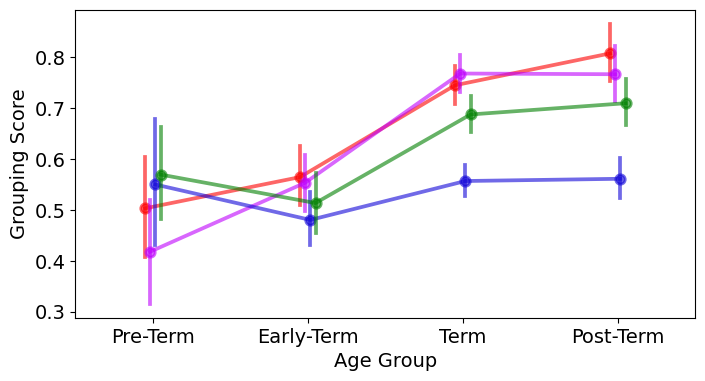

In [15]:
#line plot as a function of age_group and network1
network_colors = ['#fd0000', '#be00fd', '#1105d8', 'green']
#make age_group categorical
dist_summary_wide['age_group'] = pd.Categorical(dist_summary_wide['age_group'], categories=age_groups, ordered=True)
#make network1 categorical
dist_summary_wide['network1'] = pd.Categorical(dist_summary_wide['network1'], categories=networks, ordered=True)

#rename age_groups
dist_summary_wide['age_group'] = dist_summary_wide['age_group'].replace({'pre':'Pre-Term', 'early':'Early-Term', 'term':'Term', 'post':'Post-Term'})

plt.figure(figsize=(8,4))
sns.pointplot(x='age_group', y='similarity_diff', data=dist_summary_wide, hue='network1', palette = network_colors, ci=95, dodge=True, alpha = .6)


#set x axis fontsize
plt.xticks(fontsize = 14)
#change y axis fontsize
plt.yticks(fontsize = 14)

#change x axist title
plt.xlabel('Age Group', fontsize = 14)

#change y axis title
plt.ylabel('Grouping Score', fontsize = 14)

#remove legend
plt.legend([],[], frameon=False)

## Hierarchy Analysis

#### Hierarchy day1

In [20]:
hierarchy_summary = pd.read_csv(f'{group_params.out_dir}/derivatives/clustering/infant_all_wang_roi_hierarchy.csv')
#extract day1 infants
hierarchy_summary['age'] = (hierarchy_summary['scan_age'] - hierarchy_summary['birth_age'])*7

#extract infants that were scanned on day 1 and are either term or post-term
day1_hierarchy = hierarchy_summary[(hierarchy_summary['age'] <= 1) & (hierarchy_summary['age_group'] == 'term') | (hierarchy_summary['age'] <= 1) & (hierarchy_summary['age_group'] == 'post')]



In [8]:
#data = day1_hierarchy
#compute bootstrap confidence intervals for each network
def bootstrap_ci(data, cols, n_bootstraps=10, alpha=0.05):
    """Compute bootstrap confidence intervals for the mean of a dataset."""
    bootstrapped_means = []
    for i in range(n_bootstraps):
        sample = data.sample(n=len(data), replace=True)

        means = sample.groupby(cols).mean(numeric_only=True).reset_index()

        # Calculate the mean for each group
        bootstrapped_means.append(means['corr'].values.tolist())

    #convert to numpy array
    bootstrapped_means = np.array(bootstrapped_means)

    ci_lows = []
    ci_highs = []
    #loop through columns and compute confidence intervals
    for i in range(bootstrapped_means.shape[1]):
        lower_bound = np.percentile(bootstrapped_means[:,i], 100 * (alpha / 2))
        upper_bound = np.percentile(bootstrapped_means[:,i], 100 * (1 - alpha / 2))
        ci_lows.append(lower_bound)
        ci_highs.append(upper_bound)


    return ci_lows, ci_highs


In [18]:
ci_low,ci_high = bootstrap_ci(day1_hierarchy, ['network'], n_bootstraps=10000, alpha=0.05)
print(f'95% CI: {ci_low}, {ci_high}')

95% CI: [0.2988212110919425, 0.048064106421692246, 0.26289856526612954, 0.13717676780652188], [0.5144129751957384, 0.4043656119497298, 0.7091446447823553, 0.38444402455171967]


In [20]:
hierarchy_summary_means=  day1_hierarchy.groupby('network').mean(numeric_only=True).reset_index()
#add ci_low and ci_high to hierarchy_summary_means
hierarchy_summary_means['ci_low'] = ci_low
hierarchy_summary_means['ci_high'] = ci_high
#add network labels

In [23]:
#reorder hierarchy_summary_means by network
hierarchy_summary_means['network'] = pd.Categorical(hierarchy_summary_means['network'], categories=networks, ordered=True)

#sort by network
hierarchy_summary_means = hierarchy_summary_means.sort_values(by='network')

print(hierarchy_summary_means)

     network  birth_age  scan_age      corr      age    ci_low   ci_high
2  Occipital  40.007143  40.13775  0.492084  0.91425  0.262899  0.709145
3    Ventral  40.007143  40.13775  0.260900  0.91425  0.137177  0.384444
1    Lateral  40.007143  40.13775  0.229299  0.91425  0.048064  0.404366
0     Dorsal  40.007143  40.13775  0.408108  0.91425  0.298821  0.514413


#### Adult hierarchy

In [13]:
adult_params = params.load_group_params('adult')

adult_hiearchy = pd.read_csv(f'{adult_params.out_dir}/derivatives/clustering/adult_{atlas}_roi_hierarchy.csv')

ci_low,ci_high = bootstrap_ci(adult_hiearchy, ['network'], n_bootstraps=10000, alpha=0.05)
print(f'95% CI: {ci_low}, {ci_high}')


adult_hierarchy_means=  adult_hiearchy.groupby('network').mean(numeric_only=True).reset_index()
#add ci_low and ci_high to hierarchy_summary_means
adult_hierarchy_means['ci_low'] = ci_low
adult_hierarchy_means['ci_high'] = ci_high

95% CI: [0.482433031360305, 0.15747748869896944, 0.31758134483515604, 0.5293456445862083], [0.5693255773641518, 0.33185952083083275, 0.524463478049519, 0.6467408079422993]


In [14]:
#reorder hierarchy_summary_means by network
adult_hierarchy_means['network'] = pd.Categorical(adult_hierarchy_means['network'], categories=networks, ordered=True)

#sort by network
adult_hierarchy_means = adult_hierarchy_means.sort_values(by='network')

print(adult_hierarchy_means)

     network  birth_age  scan_age      corr    ci_low   ci_high
2  Occipital        NaN       NaN  0.419643  0.317581  0.524463
3    Ventral        NaN       NaN  0.589507  0.529346  0.646741
1    Lateral        NaN       NaN  0.245298  0.157477  0.331860
0     Dorsal        NaN       NaN  0.526329  0.482433  0.569326


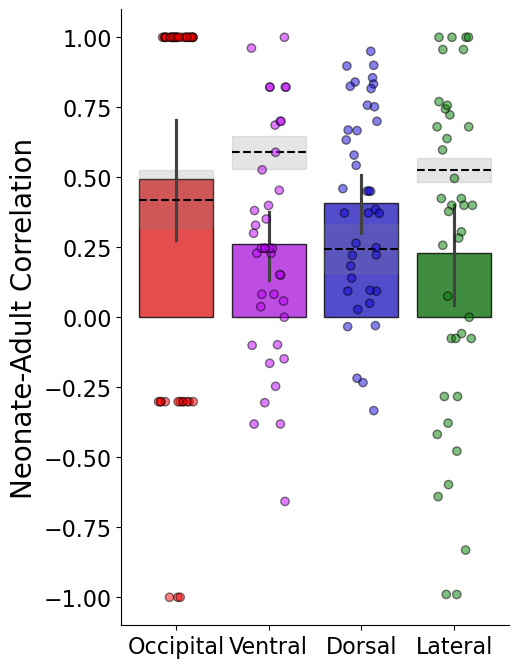

In [28]:
'''
Create bar plot of hierarchy summary
with error bars
'''
summary_df = day1_hierarchy


#plot summary_df
ax = sns.barplot(data = summary_df, x = 'network',y='corr', errorbar=('ci',95), edgecolor = 'k',palette = network_colors,
                alpha = .8)
sns.stripplot(data = summary_df,  x = 'network',y='corr', edgecolor = 'black', alpha = .5, linewidth=1,jitter = .2, size = 6,
            palette = network_colors, ax = ax)

#add noise ceilings as dot above each bar
if adult_hierarchy_means is not None:
    for i, net in enumerate(networks):
        #add noise ceiling
        #plt.plot(i, noise_ceiling_df[noise_ceiling_df['network1'] == net]['corr'].mean(), '_', color = 'gray', markersize = 15, markeredgecolor = 'k')

        #add noise ceiling as line
        plt.plot([i-.4, i+.4], [adult_hiearchy[adult_hiearchy['network'] == net]['corr'].mean(), adult_hiearchy[adult_hiearchy['network'] == net]['corr'].mean()], color = 'black', linestyle = '--')

        #add shaded region for standard error
        plt.fill_between([i-.4, i+.4], adult_hierarchy_means[adult_hierarchy_means['network'] == net]['ci_low'],
                        adult_hierarchy_means[adult_hierarchy_means['network'] == net]['ci_high'], color = 'gray', alpha = .2)

#increase font size of x and y ticks
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

#add y label
plt.ylabel('Neonate-Adult Correlation', fontsize = 20)

#add x label
#plt.xlabel('Network', fontsize = 20)

#make axes black
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

#remove top and right axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#make graph smaller
plt.gcf().set_size_inches(5,8)

#remove x axis label
plt.xlabel('')
'''
if file_name is not None:
    
    #save plot
    plt.savefig(f'{git_dir}/figures/maturity/{file_name}.png', bbox_inches = 'tight', dpi = 300)
'''

plt.show()
plt.pause(.001)


### Hierarchy as a function of age group

In [11]:
hierarchy_summary = pd.read_csv(f'{group_params.out_dir}/derivatives/clustering/infant_all_wang_roi_hierarchy.csv')
#extract day1 infants
hierarchy_summary['age'] = (hierarchy_summary['scan_age'] - hierarchy_summary['birth_age'])*7

#make age_group categorical
hierarchy_summary['age_group'] = pd.Categorical(hierarchy_summary['age_group'], categories=age_groups, ordered=True)
#make network1 categorical
hierarchy_summary['network'] = pd.Categorical(hierarchy_summary['network'], categories=networks, ordered=True)

#rename age_groups
hierarchy_summary['age_group'] = hierarchy_summary['age_group'].replace({'pre':'Pre-Term', 'early':'Early-Term', 'term':'Term', 'post':'Post-Term'})

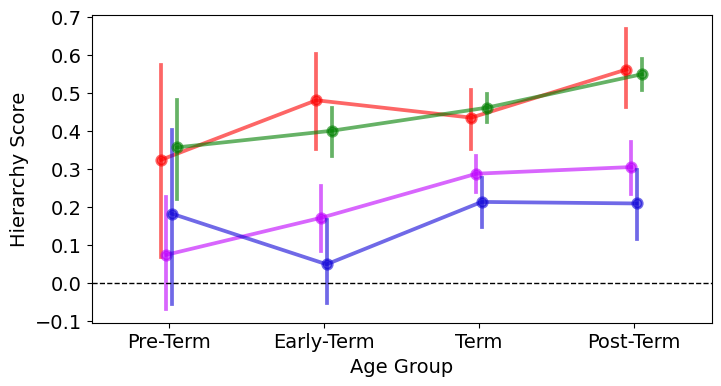

In [ ]:
'''
Unnormalized version
'''
plt.figure(figsize=(8,4))
sns.pointplot(x='age_group', y='corr', data=hierarchy_summary, hue='network', palette = network_colors, ci=95, dodge=True, alpha = .6)


#set x axis fontsize
plt.xticks(fontsize = 14)
#change y axis fontsize
plt.yticks(fontsize = 14)

#change x axist title
plt.xlabel('Age Group', fontsize = 14)

#change y axis title
plt.ylabel('Hierarchy Score', fontsize = 14)

#add dotted line at 0
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)

#remove legend
plt.legend([],[], frameon=False)

In [17]:
#Add adult mean for to each network in hiearchy summary
hierarchy_summary['adult_mean'] = np.nan

for i in networks:
    hierarchy_summary.loc[hierarchy_summary['network'] == i, 'adult_mean'] = adult_hierarchy_means[adult_hierarchy_means['network'] == i]['corr'].values[0]


#create normalized correlation by dividing corr by adult_mean
hierarchy_summary['norm_corr'] = hierarchy_summary['corr'] / hierarchy_summary['adult_mean']

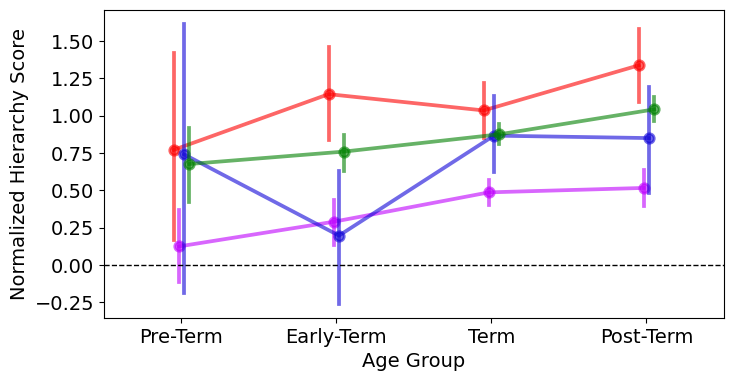

In [19]:
'''plot normalized version'''


plt.figure(figsize=(8,4))
sns.pointplot(x='age_group', y='norm_corr', data=hierarchy_summary, hue='network', palette = network_colors, ci=95, dodge=True, alpha = .6)


#set x axis fontsize
plt.xticks(fontsize = 14)
#change y axis fontsize
plt.yticks(fontsize = 14)

#change x axist title
plt.xlabel('Age Group', fontsize = 14)

#change y axis title
plt.ylabel('Normalized Hierarchy Score', fontsize = 14)

#add dotted line at 0
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)

#remove legend
plt.legend([],[], frameon=False)

## Look at all effects as a function of age

### Arealization

In [3]:
#load infant data
sub_df = pd.read_csv(f'{group_params.out_dir}/derivatives/{atlas}/infant_{atlas}_roi_similarity.csv')
adj_rois = pd.read_csv(f'{git_dir}/analysis/Wang_adjacent_labels.csv')

#add age and age group columns
sub_df['age'] = (sub_df['scan_age'] - sub_df['birth_age'])*7
sub_df['age_group'] = np.nan
for i in range(len(age_bins)-1):
    sub_df.loc[(sub_df['scan_age'] >= age_bins[i]) & (sub_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]


#group by ROIs
df_roi_summary = sub_df.groupby(['sub', 'ses','network1','network2', 'roi1','roi2','hemi_similarity','roi_similarity','network_similarity', 'age_group']).mean(numeric_only=True).reset_index()
df_roi_summary = df_roi_summary[df_roi_summary['hemi_similarity'] == 'diff']


#add adjacency category to roi_similarity
#loop over roi1 and if roi2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
df_roi_summary['roi_similarity_adj'] = np.nan


#label same, adjacent, and distant areas
for roi1,adj1, adj2 in zip(adj_rois['label'], adj_rois['adjacent1'], adj_rois['adjacent2']):
    #if ro2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
    df_roi_summary['roi_similarity_adj'] = np.where((df_roi_summary['roi1'] == roi1) & (df_roi_summary['roi2'] == adj1) | (df_roi_summary['roi1'] == roi1) & (df_roi_summary['roi2'] == adj2),
                                                     'Adjacent', df_roi_summary['roi_similarity_adj'])
    
    #if roi1 == roi2, set roi_similarity to same
    df_roi_summary['roi_similarity_adj'] = np.where(df_roi_summary['roi1'] == df_roi_summary['roi2'], 'Same\nArea', df_roi_summary['roi_similarity_adj'])

    #if roi1 != roi2 and roi_similarity_adj is nan, set roi_similarity to distant
    df_roi_summary['roi_similarity_adj'] = np.where((df_roi_summary['roi1'] != df_roi_summary['roi2']) & (df_roi_summary['roi_similarity_adj'] != 'Adjacent') & (df_roi_summary['roi_similarity_adj'] != 'same'),
                                                     'Distal', df_roi_summary['roi_similarity_adj'])



In [4]:
#create summary by roi_similarity_adj
df_network_summary = df_roi_summary.groupby(['sub','ses','age_group','network1','roi_similarity_adj']).mean(numeric_only=True).reset_index()

#pivot so that sub and network are indices and roi_similarity_adj is columns
df_network_summary = df_network_summary.pivot_table(index = ['sub', 'ses', 'age_group', 'network1'], columns = 'roi_similarity_adj', values = 'fc').reset_index()

#make new column with arealization index
df_network_summary['adjacent_arealization'] = df_network_summary['Same\nArea'] - df_network_summary['Adjacent']
df_network_summary['distant_arealization'] = df_network_summary['Same\nArea'] - df_network_summary['Distal']

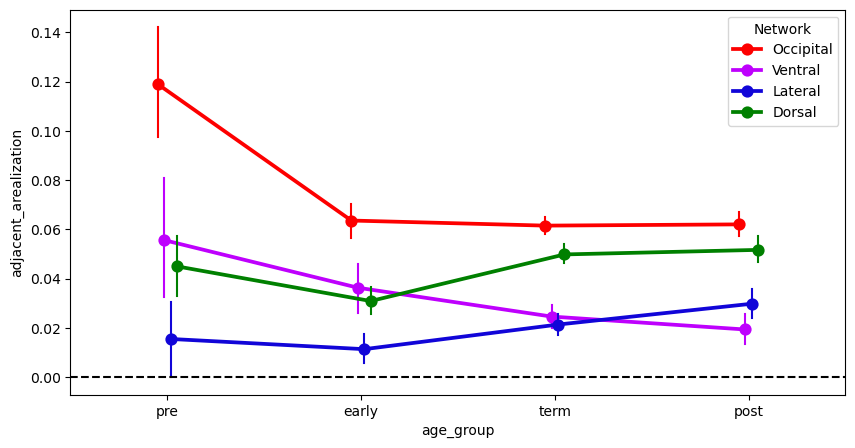

In [5]:
#make age_group categorical
df_network_summary['age_group'] = pd.Categorical(df_network_summary['age_group'], categories=age_groups, ordered=True)
#network categorical
df_network_summary['network1'] = pd.Categorical(df_network_summary['network1'], categories=networks, ordered=True)

#point plot of arealization index
plt.figure(figsize=(10,5))
sns.pointplot(x='age_group', y='adjacent_arealization', data=df_network_summary, hue='network1', palette=network_colors, ci=95, dodge=True, markers='o', linestyles='-', errwidth=1.5, capsize=0)

#dotted line at 0
plt.axhline(y=0, color = 'k', linestyle = '--')

#put legend outside of plot
plt.legend(bbox_to_anchor=(6.04, 1), loc="upper left")
#Change legend title to network
plt.legend(title='Network')

#plt.ylim(-.1,.25)

#### plot arealization as function of distance


In [ ]:
network_rois = [['V1v', 'V2v','V3v'],['V1d', 'V2d','V3d'],['hV4','VO1','VO2','PHC1','PHC2'], ['LO1','LO2','hMT','MST'], [ 'V3a','V3b','IPS0','IPS1','IPS2','IPS3', 'IPS4', 'IPS5', 'SPL1']]
networks = ['Occipital_V','Occipital_D', 'Ventral', 'Lateral', 'Dorsal']

#for each roi add number corresponding to its position in the network
df_roi_summary['network1'] = np.nan
df_roi_summary['network2'] = np.nan
df_roi_summary['roi_num1'] = np.nan
df_roi_summary['roi_num2'] = np.nan


for network, rois in zip(networks, network_rois):
    for i, roi in enumerate(rois):
        df_roi_summary['network1'] = np.where(df_roi_summary['roi1'] == roi, network, df_roi_summary['network1'])
        df_roi_summary['network2'] = np.where(df_roi_summary['roi2'] == roi, network, df_roi_summary['network2'])
        df_roi_summary['roi_num1'] = np.where(df_roi_summary['roi1'] == roi, i, df_roi_summary['roi_num1'])
        df_roi_summary['roi_num2'] = np.where(df_roi_summary['roi2'] == roi, i, df_roi_summary['roi_num2'])


#only keep rows where network1 and network2 are the same
#df_network_summary = df_roi_summary[df_roi_summary['network1'] == df_roi_summary['network2']]
df_network_summary = df_roi_summary


#add column with num difference between roi1 and roi2
df_network_summary['roi_dist'] = np.abs(df_network_summary['roi_num1'] - df_network_summary['roi_num2'])


#rename occipital_d and occipital_v to occipital
df_network_summary['network1'] = df_network_summary['network1'].replace('Occipital_V', 'Occipital')
df_network_summary['network1'] = df_network_summary['network1'].replace('Occipital_D', 'Occipital')
#same for network2
df_network_summary['network2'] = df_network_summary['network2'].replace('Occipital_V', 'Occipital')
df_network_summary['network2'] = df_network_summary['network2'].replace('Occipital_D', 'Occipital')

#remove all rows with distance > 3 
df_network_summary = df_network_summary[df_network_summary['roi_dist'] <= 2]

#group by roi_dist and network1
df_network_summary = df_network_summary.groupby(['sub','ses','age_group','network1','roi_dist']).mean(numeric_only=True).reset_index()

#compute slope for each sub, ses, and network
slope = []
for sub in df_network_summary['sub'].unique():

    curr_sub = df_network_summary[df_network_summary['sub'] == sub]

    for ses in curr_sub['ses'].unique():

        curr_ses = curr_sub[curr_sub['ses'] == ses]
        #check if curr_sub is empty

        for network in df_network_summary['network1'].unique():
            print(network)
            curr_network = curr_sub[curr_sub['network1'] == network]
            #compute slope
            slope.append(np.polyfit(curr_network['roi_dist'], curr_network['fc'], 1)[0])


#pivot so that sub and network are indices and roi_dist is columns
df_network_summary = df_network_summary.pivot_table(index = ['sub', 'ses', 'age_group', 'network1'], columns = 'roi_dist', values = 'fc').reset_index()

#add slope column
df_network_summary['slope'] = slope

#add slope column
#df_network_summary['slope'] = np.nan

#compute slope across 0, 1, 2  cols



sub-CC00056XX07
['ses-10700']
ses-10700
Dorsal
Lateral
Occipital
Ventral
sub-CC00057XX08
['ses-11002']
ses-11002
Dorsal
Lateral
Occipital
Ventral
sub-CC00060XX03
['ses-12501']
ses-12501
Dorsal
Lateral
Occipital
Ventral
sub-CC00063AN06
['ses-15102']
ses-15102
Dorsal
Lateral
Occipital
Ventral
sub-CC00064XX07
['ses-18303']
ses-18303
Dorsal
Lateral
Occipital
Ventral
sub-CC00065XX08
['ses-18600']
ses-18600
Dorsal
Lateral
Occipital
Ventral
sub-CC00066XX09
['ses-19200']
ses-19200
Dorsal
Lateral
Occipital
Ventral
sub-CC00067XX10
['ses-20200']
ses-20200
Dorsal
Lateral
Occipital
Ventral
sub-CC00068XX11
['ses-20701']
ses-20701
Dorsal
Lateral
Occipital
Ventral
sub-CC00069XX12
['ses-26300']
ses-26300
Dorsal
Lateral
Occipital
Ventral
sub-CC00071XX06
['ses-27000']
ses-27000
Dorsal
Lateral
Occipital
Ventral
sub-CC00073XX08
['ses-27800']
ses-27800
Dorsal
Lateral
Occipital
Ventral
sub-CC00074XX09
['ses-28000']
ses-28000
Dorsal
Lateral
Occipital
Ventral
sub-CC00075XX10
['ses-28400']
ses-28400
Dorsal
Late

<Axes: xlabel='age_group', ylabel='slope'>

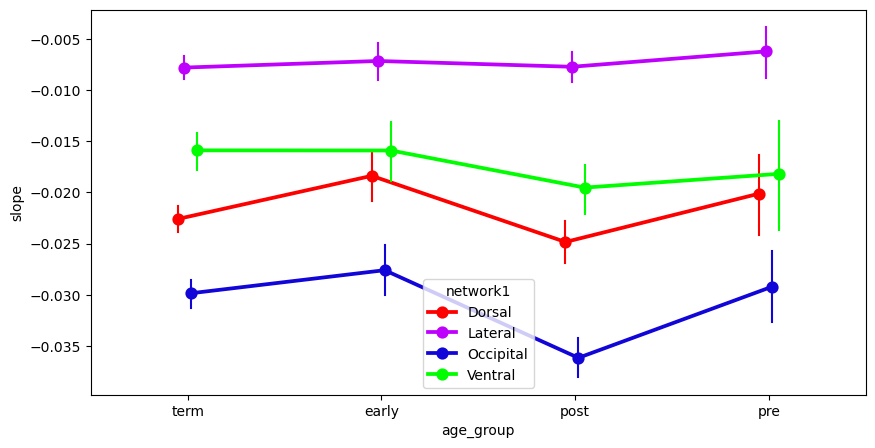

In [51]:
#plot slope as a function of age_group and network
plt.figure(figsize=(10,5))
sns.pointplot(x='age_group', y='slope', data=df_network_summary, hue='network1', palette=network_colors, ci=95, dodge=True, markers='o', linestyles='-', errwidth=1.5, capsize=0)

In [48]:
curr_sub = df_network_summary[df_network_summary['sub'] == sub]
curr_sub = curr_sub[curr_sub['ses'] == ses]
curr_df = curr_sub[curr_sub['network1'] == network]

<Axes: xlabel='roi_dist', ylabel='fc'>

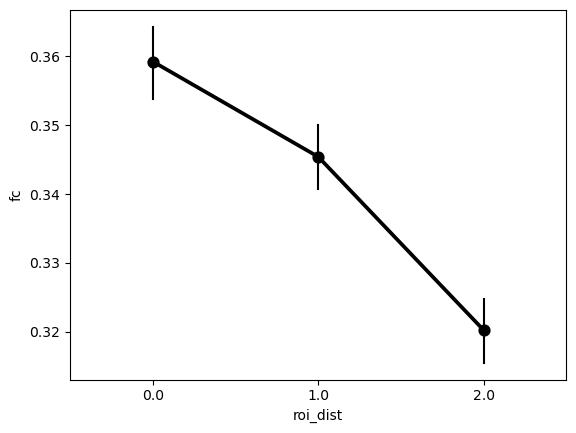

In [31]:
#plot arealization by roi_dist as point plot
plt.figure()
sns.pointplot(x='roi_dist', y='fc', data=df_network_summary, ci=95, markers='o', linestyles='-', errwidth=1.5, capsize=0, color='k')

In [3]:
#load infant data
sub_df = pd.read_csv(f'{group_params.out_dir}/derivatives/{atlas}/infant_{atlas}_roi_similarity.csv')



#add age and age group columns
sub_df['age'] = (sub_df['scan_age'] - sub_df['birth_age'])*7
sub_df['age_group'] = np.nan
for i in range(len(age_bins)-1):
    sub_df.loc[(sub_df['scan_age'] >= age_bins[i]) & (sub_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]




# group by hemi_simlarity, roi_similarity, network_similarity
age_df = sub_df.groupby(['sub', 'ses', 'age','age_group','hemi_similarity','roi_similarity','network_similarity', 'network1']).mean(numeric_only=True).reset_index()
#round all values to 4 decimal places
age_df = sub_df.round(4)


#extract only diff hemi_similarity
age_df = age_df[age_df['hemi_similarity'] == 'diff']
#extract only in same network similarity
age_df = age_df[age_df['network_similarity'] == 'same']

#pivot so that sub and network are indices and roi_similarity is columns
age_df = age_df.pivot_table(index = ['sub','ses','age_group','scan_age','birth_age','age','network1'], columns = 'roi_similarity', values = 'fc').reset_index()

#Create new column that is the difference between same and diff
age_df['arealization_index'] = age_df['same'] - age_df['diff']

#save 
age_df.to_csv(f'{git_dir}/results/infant_{atlas}_arealization_index.csv', index = False)

(-0.1, 0.25)

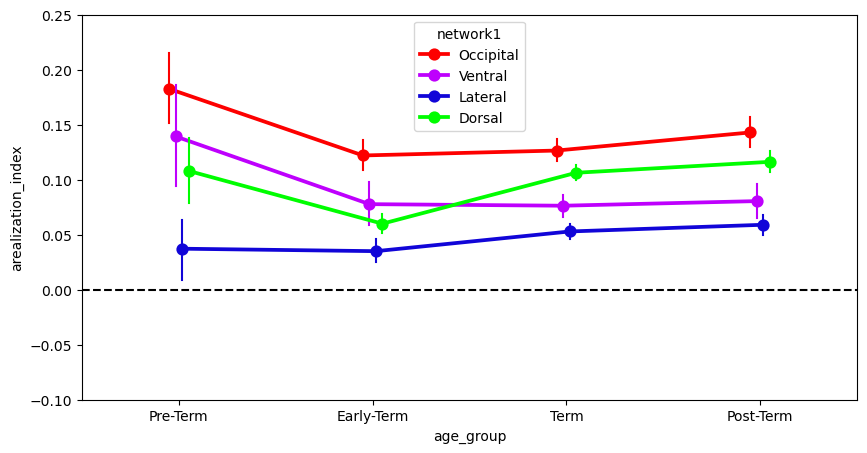

In [14]:
#make age_group categorical
age_df['age_group'] = pd.Categorical(age_df['age_group'], categories=age_groups, ordered=True)
#network categorical
age_df['network1'] = pd.Categorical(age_df['network1'], categories=networks, ordered=True)

#point plot of arealization index
plt.figure(figsize=(10,5))
sns.pointplot(x='age_group', y='arealization_index', data=age_df, hue='network1', palette=network_colors, ci=95, dodge=True, markers='o', linestyles='-', errwidth=1.5, capsize=0)

#dotted line at 0
plt.axhline(y=0, color = 'k', linestyle = '--')

plt.ylim(-.1,.25)

### Grouping